In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from dateutil import parser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics
from collections import defaultdict
import json
import datetime
import time

DATA_PATH = '../processed_data/'

all_data = pd.read_csv(DATA_PATH + 'allDataCombined.csv')
price_data = pd.read_csv(DATA_PATH + 'priceData.csv')
df = pd.merge(all_data, price_data, on="timestamp")
df['date'] = df['timestamp'].apply(lambda x: parser.parse(x).date())
df['time'] = df['timestamp'].apply(lambda x: parser.parse(x).strftime("%H:%M:%S"))
corr = []
corr_all = []
pnl = defaultdict(list)
index = 0

df['NOPE'] = df['NOPE_busVolume'] * 100

# remove feb 19 2020 through march 23 2020 for testing short strategies

In [2]:
#for short testing, remove feb 19 2020 to march 23 2020
temp1 = df[df['date'] < datetime.date(2020, 2, 19)] 
temp2 = df[df['date'] > datetime.date(2020, 3, 23)] 

In [3]:
dfshort = pd.concat([temp1, temp2], axis=0)

In [4]:
dfshort = dfshort.reset_index(drop=True)

In [5]:
#split into train, test sets using even, odd days
dfshort['date2'] = pd.to_datetime(dfshort['date'])

In [26]:
def backtest_short(day_group, short_entry, short_exit, stop, cutoff_time, leverage):
    values = []
    trade_in_progress = False
    entry_price = None
    exit_price = None
    total_pnl = 0
    for index, row in day_group.iterrows():
        if row['NOPE_busVolume']*100 >= short_entry and not trade_in_progress and row['time'] > '09:45:00' and row['time'] < 'cutoff_time':
            entry_price = (row['NOPE_busVolume']*100, row['time'], row['active_underlying_price'])
            trade_in_progress = True
        if trade_in_progress and (row['NOPE_busVolume']*100 <= short_exit or row['NOPE_busVolume']*100 >= stop):
            exit_price = (row['NOPE_busVolume']*100,row['time'],row['active_underlying_price'])
            values.append((entry_price, exit_price))
            total_pnl = total_pnl + (entry_price[2] - exit_price[2])*leverage
            trade_in_progress = False
            entry_price = None
            exit_price = None
        if row['time'] == '16:00:00':
            if trade_in_progress:
                exit_price = (row['NOPE_busVolume']*100,row['time'],row['active_underlying_price'])
                values.append((entry_price, exit_price))
                total_pnl = total_pnl + (entry_price[2] - exit_price[2])
                trade_in_progress = False
                entry_price = None
                exit_price = None
            break
    return (values, total_pnl)

# Testing different entries, 15 stop, 1PM cutoff

In [18]:
pnl_list = []
t0 = time.time()

pnl_list = np.zeros([int((40-15)/5)])


for i, short_entry in enumerate(range(15, 40, 5)):
    total_pnl = defaultdict(tuple)
    real_total_pnl = 0
    for name, group in dfshort.groupby('date'):
        total_pnl[str(name)] = backtest_short(group, short_entry, 15, 200, '14:00:00')
        real_total_pnl = real_total_pnl + total_pnl[str(name)][1]
    pnl_list[i] = real_total_pnl

t1 = time.time()
t1 - t0

5.50857400894165

In [19]:
pnl_list

array([45.3918, 40.648 , 38.879 , 46.665 , 39.734 ])

# 30 is best static entry, now test static stop loss

In [9]:
pnl_list = []
t0 = time.time()

pnl_list = np.zeros([int((200-30)/5)])


for k, stop_loss in enumerate(range(30, 200, 5)):
    total_pnl = defaultdict(tuple)
    real_total_pnl = 0
    for name, group in dfshort.groupby('date'):
        total_pnl[str(name)] = backtest_short(group, 30, 15, stop_loss, '14:30:00')
        real_total_pnl = real_total_pnl + total_pnl[str(name)][1]
    pnl_list[k] = real_total_pnl

t1 = time.time()
t1 - t0

38.51829123497009

In [10]:
print(pnl_list)

[ 0.     4.152 16.187 23.944 27.455 27.796 25.037 36.377 39.831 40.319
 41.365 42.061 46.427 48.195 48.452 48.599 49.001 47.404 47.514 44.308
 44.989 45.283 46.39  46.068 46.884 47.012 47.393 48.403 47.903 46.96
 47.095 47.135 46.595 46.585]


Text(0, 0.5, 'PnL, 30/15 static entry/exit')

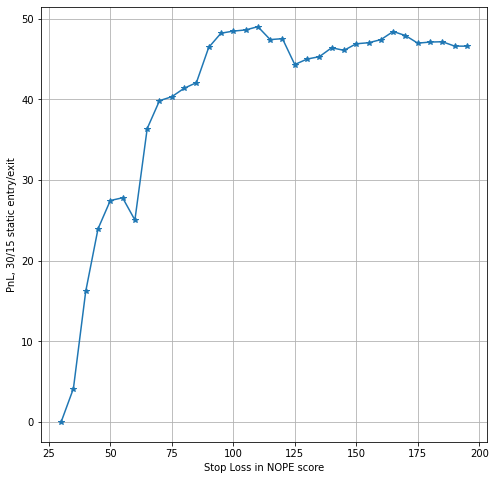

In [21]:
stoploss = [i for i in range(30, 200, 5)]

plt.figure(figsize=(8, 8))
plt.plot(stoploss, pnl_list, '*-')
plt.grid()
plt.xlabel("Stop Loss in NOPE score")
plt.ylabel("PnL, 30/15 static entry/exit")

In [22]:
#check time

times = ['12:00:00', '12:30:00', '13:00:00', '13:30:00', '14:00:00', '14:30:00', '15:00:00']

pnl_list = np.zeros([7])

t0 = time.time()
for i, elem in enumerate(times):
    total_pnl = defaultdict(tuple)
    real_total_pnl = 0
    for name, group in dfshort.groupby('date'):
        total_pnl[str(name)] = backtest_short(group, 30, 15, 200, elem)
        real_total_pnl = real_total_pnl + total_pnl[str(name)][1]
    pnl_list[i] = real_total_pnl

t1 = time.time()
t1 - t0

7.531209230422974

In [23]:
pnl_list

array([47.159, 47.159, 47.159, 47.159, 47.159, 47.159, 47.159])

# Test leverage

In [29]:
pnl_list = np.zeros([30])
t0 = time.time()
for i, leverage in enumerate(range(1, 30, 5)):
    total_pnl = defaultdict(tuple)
    real_total_pnl = 0
    for name, group in dfshort.groupby('date'):
        total_pnl[str(name)] = backtest_short(group, 30, 15, 200, '14:00:00', leverage)
        real_total_pnl = real_total_pnl + total_pnl[str(name)][1]
    pnl_list[i] = real_total_pnl

t1 = time.time()
t1 - t0

6.809038162231445

In [31]:
pnl_list

array([  47.159,  524.709, 1002.259, 1479.809, 1957.359, 2434.909,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ])